# Progression of selfplay games
Move number and final score
* Games 0 to 59: Fixed move order, first 2048 tile achieved (game 0).
* Games 60 to 79: `20190625/10_60_epox60_lr0.125_e49`, first 4096 tile achieved (game 79).
* Games 80 to 99: `20190701/60_80_epox10_lr0.0043pre_e9`
* Games 100 to 120: `20190710/80_100_epox10_lr0.0043pre_e9`, first 8192 tile achieved (game 100).
* Games 120 to 130: `20190715/100_120_epox5_lr0.0034pre_e4`, stronger network but worse play.

In [1]:
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
os.chdir('selfplay')

In [2]:
indices = []
moves = []
scores = []
tiles = []
i = 0
while True:
    try:
        x = np.load(str(i).zfill(5)+'.npz')
        indices.append(i)
        moves.append(len(x['moves']))
        scores.append(x['score'])
        tiles.append(np.amax(x['boards'][-1]))
        i += 1
    except FileNotFoundError:
        print('Got {} games'.format(i))
        break

Got 130 games


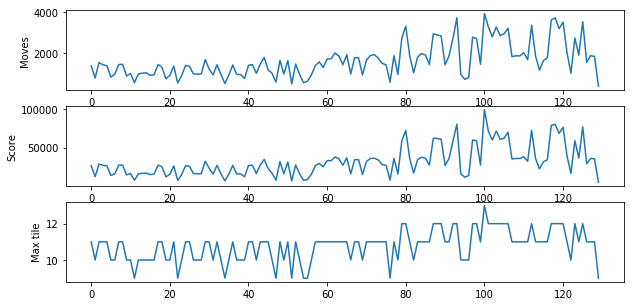

In [3]:
plt.subplots(figsize=(10, 5))
plt.subplot(311)
plt.plot(indices, moves)
plt.ylabel('Moves')
plt.subplot(312)
plt.plot(indices, scores)
plt.ylabel('Score')
plt.subplot(313)
plt.plot(indices, tiles)
plt.ylabel('Max tile')
plt.show()

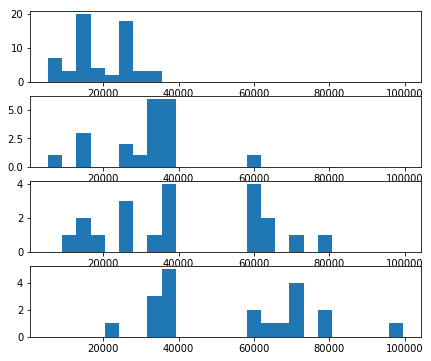

Multimodal distribution corresponding to tile fusion cascades


In [5]:
plt.subplots(figsize=(7, 6))
plt.subplot(411)
plt.hist(scores[:60], range=(min(scores), max(scores)), bins=25)
plt.subplot(412)
plt.hist(scores[60:80], range=(min(scores), max(scores)), bins=25)
plt.subplot(413)
plt.hist(scores[80:100], range=(min(scores), max(scores)), bins=25)
plt.subplot(414)
plt.hist(scores[100:120], range=(min(scores), max(scores)), bins=25)
plt.show()
print('Multimodal distribution corresponding to tile fusion cascades')

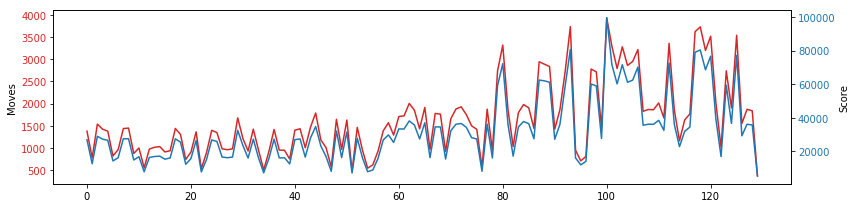

In [7]:
fig, ax1 = plt.subplots(figsize=(12,3))

color = 'tab:red'
ax1.plot(indices, moves, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Moves')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.plot(indices, scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Score')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [9]:
# Test if variances are the same
print(stats.bartlett(moves[:60], moves[60:80]))
print(stats.bartlett(moves[60:80], moves[80:100]))
print(stats.bartlett(moves[80:100], moves[100:120]))
print(stats.bartlett(moves[100:120], moves[120:]))

BartlettResult(statistic=4.1909838454048725, pvalue=0.040639506037814854)
BartlettResult(statistic=6.461949195341188, pvalue=0.011020868702808438)
BartlettResult(statistic=0.030544388242263333, pvalue=0.8612607321877558)
BartlettResult(statistic=0.3465098974863574, pvalue=0.556095472763198)


In [11]:
# Test if means are the same
print(stats.ttest_ind(moves[:60], moves[60:80], equal_var=False))
print(stats.ttest_ind(moves[60:80], moves[80:100], equal_var=False))
print(stats.ttest_ind(moves[80:100], moves[100:120], equal_var=True))
print(stats.ttest_ind(moves[100:120], moves[120:], equal_var=True))

Ttest_indResult(statistic=-4.401760288102386, pvalue=0.00017058823827982228)
Ttest_indResult(statistic=-1.9633788508141254, pvalue=0.05913863458903228)
Ttest_indResult(statistic=-1.9575760583063022, pvalue=0.05765366795255532)
Ttest_indResult(statistic=1.599518160944508, pvalue=0.12093010973519536)


Games played with the neural network (#60 and above) have statistically higher scores than with fixed order. Variance also seems to be larger.

Games 120-130 seem to be worse than games 100-120. Although the network is stronger as measured by average log score of 1000 mcts lines, perhaps this is the wrong metric. I will switch strategies and try the conservative approach, choosing the move that has the highest minimum score.

# Move distribution

In [12]:
moves = []
for i in range(0, len(indices)-len(indices)%10, 10):
    m = []
    for j in range(i, i+10):
        x = np.load(str(j).zfill(5)+'.npz')
        m.extend(x['moves'])
    moves.append(m)

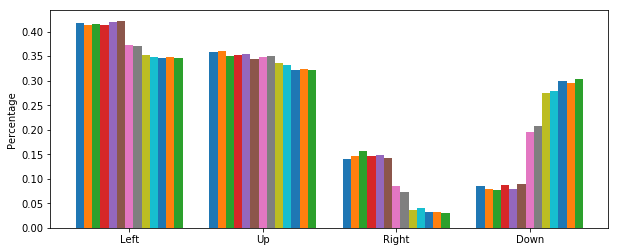

In [13]:
plt.figure(figsize=(10, 4))
plt.hist(moves, np.arange(5)-0.5, density=True)
plt.xticks(np.arange(4), ['Left', 'Up', 'Right', 'Down'])
# plt.legend([str(i) for i in range(0, len(indices), 10)])
plt.ylabel('Percentage')
plt.show()

Corrected a bug in the `moves` code above. Distribution is about the same.

In [14]:
import pandas as pd
import seaborn as sns

In [15]:
moves = pd.DataFrame(columns=['group','Left','Up','Right','Down'])
for i in indices:
    x = np.load(str(i).zfill(5)+'.npz')
    hist = np.histogram(x['moves'], bins=np.arange(5))[0]
    hist = hist / hist.sum()
    moves = moves.append({'group': 'Fixed' if i < 60 else 'Network',
                          'Left': hist[0],
                          'Up': hist[1],
                          'Right': hist[2],
                          'Down': hist[3]},
                          ignore_index=True)

In [16]:
moves = pd.melt(moves, id_vars='group', var_name='move', value_name='percent')

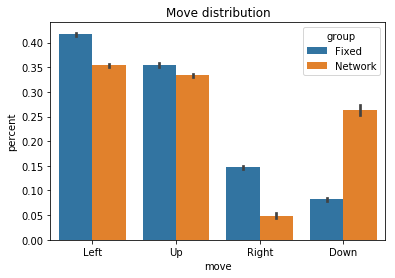

In [17]:
# Note: seaborn error bars are 95% CI of mean
ax = sns.barplot(x='move', y='percent', hue='group', data=moves)
ax.set_title('Move distribution')
plt.show()

Down moves are much higher in the NN games. Perhaps a LUDR fixed move order is superior to a LURD move order? I tested this, and it does seem to be the case (a slight improvement with LUDR over LURD).